# What drives the price of a car?


**OVERVIEW**

In this application, you will explore a dataset from Kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications, we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

### Business Understanding

The client is a used car dealer who aims to understand what customers value in a used car and how this translates into prices. This can be framed as a supervised regression problem where the target variable is the price of a used car and its predictors are observable vehicle attributes like year, model, conditions, etc. The model should be good at predicting prices based on observed attributes, but it should also be useful for interpreting coefficient values to understand which attributes are more influential on prices than others. This will enable our client to focus their inventory on cars with attributes that customers value most. 

### Data Understanding

**Steps for Understanding Missing Values**
- Load the dataset and inspect shapes/column types
- Summarize % missing values in each column. 
- This will help me understand which columns can be imputed for missing values, and which of them need to be dropped.



In [1]:
# Import packages
import pandas as pd
import numpy as np
import scipy.stats as stats
from statsmodels.stats.oneway import anova_oneway

import matplotlib.pyplot as plt
import seaborn as sns

# Environment settings
pd.options.display.max_columns = 30
pd.options.display.float_format = '{:.7g}'.format
sns.set_theme(style="whitegrid")
sns.set_palette("tab10")

In [2]:
# Read in analysis data
df = pd.read_csv('data/vehicles.csv')
df = df.drop(columns=['id','VIN','region','state'])

numeric_cols = ['year', 'odometer', 'cylinders']
highdim_cols = ['manufacturer','model']
categ_cols = list(set(df.columns) - set(numeric_cols) - set(highdim_cols) - {'price'})

In [3]:
# Number of rows and columns
display(df.shape)
display(df.info())

(426880, 14)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   price         426880 non-null  int64  
 1   year          425675 non-null  float64
 2   manufacturer  409234 non-null  object 
 3   model         421603 non-null  object 
 4   condition     252776 non-null  object 
 5   cylinders     249202 non-null  object 
 6   fuel          423867 non-null  object 
 7   odometer      422480 non-null  float64
 8   title_status  418638 non-null  object 
 9   transmission  424324 non-null  object 
 10  drive         296313 non-null  object 
 11  size          120519 non-null  object 
 12  type          334022 non-null  object 
 13  paint_color   296677 non-null  object 
dtypes: float64(2), int64(1), object(11)
memory usage: 45.6+ MB


None

In [4]:
# Missing value percentages
df.isnull().mean() * 100

price                  0
year           0.2822807
manufacturer    4.133714
model           1.236179
condition       40.78523
cylinders       41.62247
fuel            0.705819
odometer        1.030735
title_status    1.930753
transmission   0.5987631
drive           30.58635
size            71.76748
type            21.75272
paint_color     30.50108
dtype: float64

In [5]:
# Some rows have most columns missing, which is problematic
df[numeric_cols + categ_cols].isnull().all(axis=1).sum() 

np.int64(68)

**Steps for Understanding Outliers / Problematic Values**
- Summary statistics & histogram for target variable (price) + its log
- Summary statistics & histogram for numeric predictors (year, odometer) + their logs
- Bar plots for value counts on categorical predictors (manufacturer, model, condition, cylinders, fuel, title_status, transmission, VIN, drive, size, type, paint_color)
- This will help me understand which columns have outliers or unusual values that need to be removed

In [6]:
# Log transformations of continuous variables
df['log_price'] = np.log(1+df['price'])
df['log_odometer'] = np.log(1+df['odometer'])

In [7]:
# Summary statistics
    # Prices/odometers have values near zero that need to be removed (< 100 for price and odometer)
    # We might want to remove very high values for price / odometer
    # Should drop cars produce prior to 1960
with pd.option_context('display.max_rows', None):
    pctiles = np.concatenate([np.arange(.01,.05,.001), np.arange(0.05,0.95,0.15), np.arange(.95,1,.001)])
    pctiles = np.round(pctiles, decimals=3)
    pctiles = np.unique(pctiles)
    display(df[['year','odometer','price']].describe(percentiles=pctiles))

,year,odometer,price
count,425675,422480,426880
mean,2011.235,98043.33,75199.03
std,9.45212,213881.5,1.218228e+07
min,1900,0,0
1%,1967,2,0
1.1%,1968,5,0
1.2%,1969,10,0
1.3%,1970,13,0
1.4%,1972,28,0
1.5%,1973,74,0


In [8]:
df['year'].value_counts(normalize=True, dropna=False).sort_index()

year
1900   2.811094e-05
1901   7.027736e-06
1902   2.342579e-06
1903   2.811094e-05
1905   2.342579e-06
           ...     
2019     0.05944293
2020     0.04520708
2021    0.005612819
2022    0.000311563
NaN     0.002822807
Name: proportion, Length: 115, dtype: float64

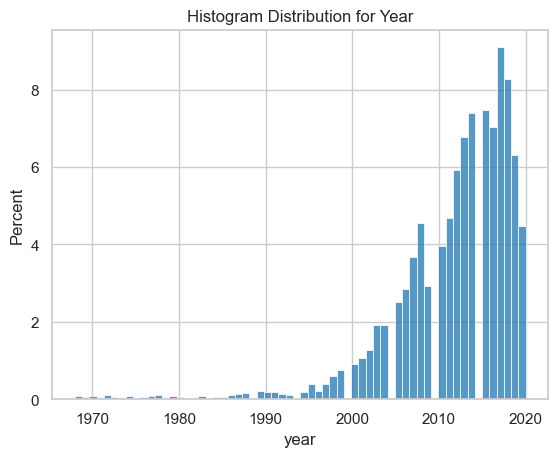

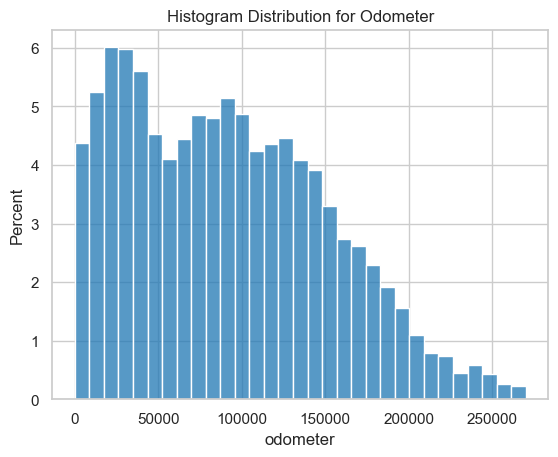

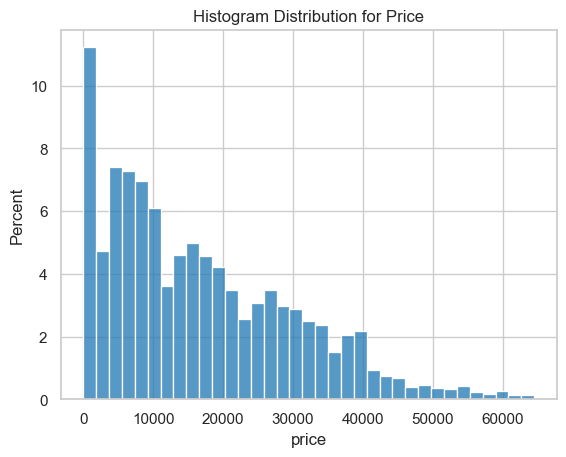

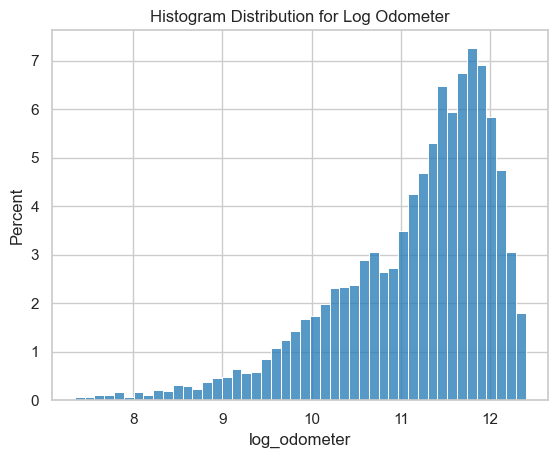

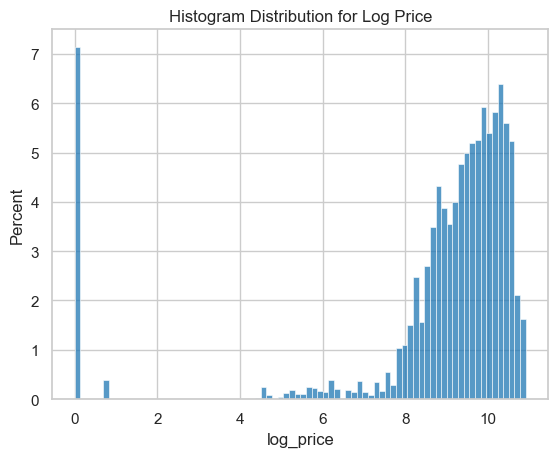

In [9]:
# Histograms for numeric columns
# Implications:
    # Price has zero values that need to be removed (likely incorrect)
    # Log price/odometer have more meaningful variation than price/odometer
    # Focus on cars after 2000, which probably excluded "classic" models
sample = df.sample(10000).reset_index(drop=True)

for col in ['year','odometer','price','log_odometer','log_price']:
    q1,q99 = sample[col].quantile([0.01,0.99])
    sample = sample[(sample[col] >= q1) & (sample[col] <= q99)]
    sns.histplot(data=sample, x=col, stat='percent')
    plt.title(f'Histogram Distribution for {col.replace('_', ' ').title()}')
    plt.show()
    plt.savefig(f'images/hist_{col}.png')
    plt.close()

In [10]:
# Manufacturer and Model are high-dimensional categorical columns. 
# Should probably be target-encoded
display(df['manufacturer'].value_counts(normalize=True, dropna=False))
display(df['model'].value_counts(normalize=True, dropna=False))

manufacturer
ford                 0.1662879
chevrolet            0.1289918
toyota              0.08012088
honda               0.04982431
nissan              0.04466595
jeep                0.04454179
ram                 0.04296758
NaN                 0.04133714
gmc                 0.03932018
bmw                 0.03443356
dodge               0.03210973
mercedes-benz       0.02768225
hyundai             0.02421758
subaru              0.02224278
volkswagen           0.0218914
kia                 0.01981119
lexus               0.01920915
audi                0.01774035
cadillac            0.01628795
chrysler            0.01412809
acura               0.01400394
buick               0.01288653
mazda               0.01271317
infiniti            0.01124906
lincoln            0.009885682
volvo              0.007903861
mitsubishi         0.007711769
mini               0.005565967
pontiac             0.00535982
rover              0.004949869
jaguar             0.004558658
porsche            0.00324

model
f-150                       0.01876171
NaN                         0.01236179
silverado 1500              0.01204085
1500                       0.009864599
camry                      0.007343984
                              ...     
plymouth fury 1           2.342579e-06
f550 box truck delivery   2.342579e-06
duramax 2500hd            2.342579e-06
3 s sport                 2.342579e-06
Paige Glenbrook Touring   2.342579e-06
Name: proportion, Length: 29650, dtype: float64

In [11]:
# Cylinders is mostly a numeric column, other than "other"
df['cylinders'].value_counts(normalize=True, dropna=False).sort_index()

cylinders
10 cylinders   0.003408452
12 cylinders   0.000489599
3 cylinders    0.001534389
4 cylinders      0.1818825
5 cylinders    0.004010495
6 cylinders      0.2205983
8 cylinders      0.1688109
other          0.003040667
NaN              0.4162247
Name: proportion, dtype: float64

In [12]:
# (convert cylinders to numeric)
if df['cylinders'].dtype == 'object':
    df['cylinders'] = df['cylinders'].str.replace(' cylinders', '')
    df['cylinders'] = df['cylinders'].str.replace('other', '')
    df['cylinders'] = pd.to_numeric(df['cylinders'], errors='coerce')
    display(df['cylinders'].value_counts(normalize=True, dropna=False).sort_index())

cylinders
3     0.001534389
4       0.1818825
5     0.004010495
6       0.2205983
8       0.1688109
10    0.003408452
12    0.000489599
NaN     0.4192654
Name: proportion, dtype: float64

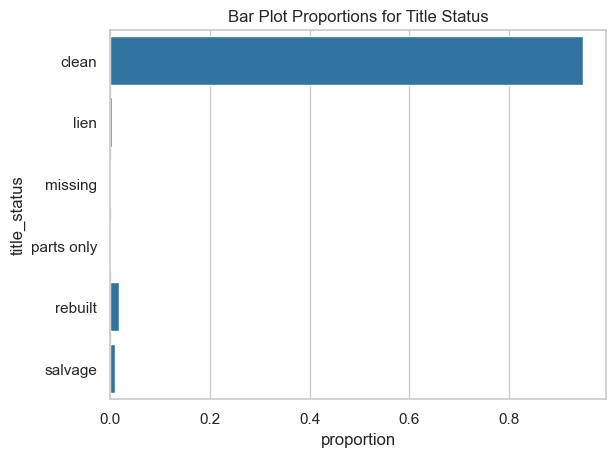

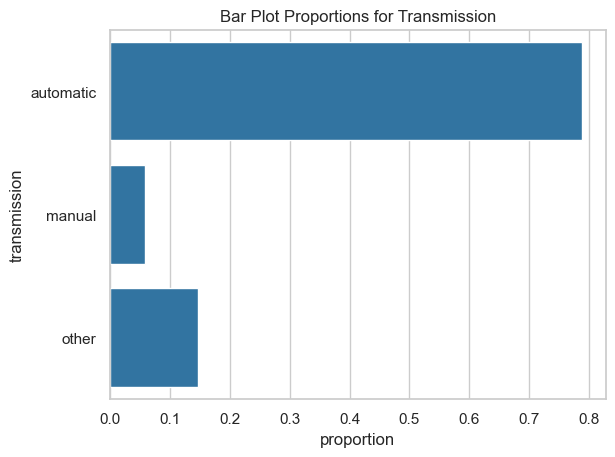

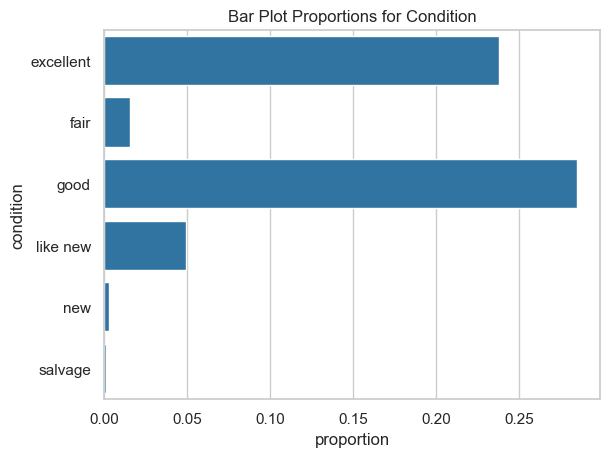

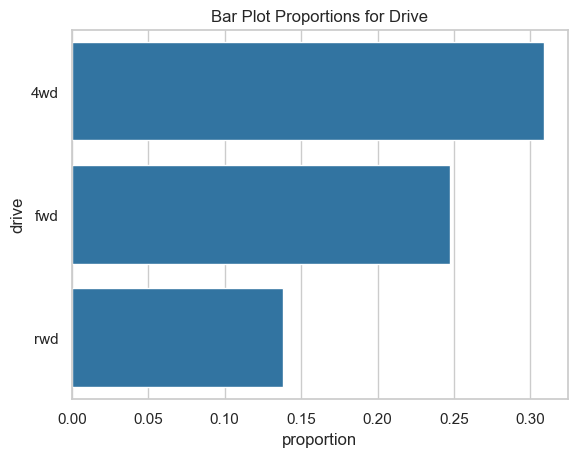

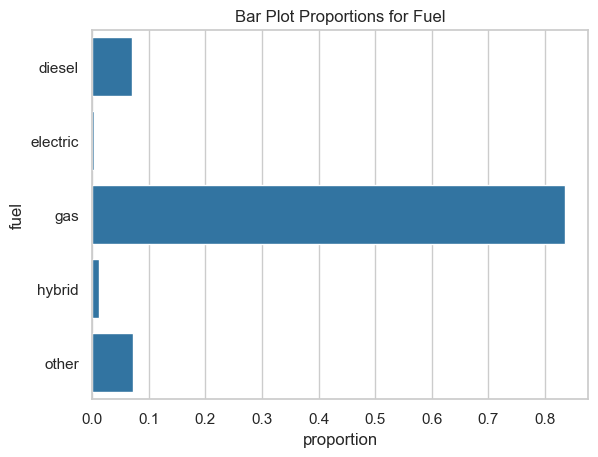

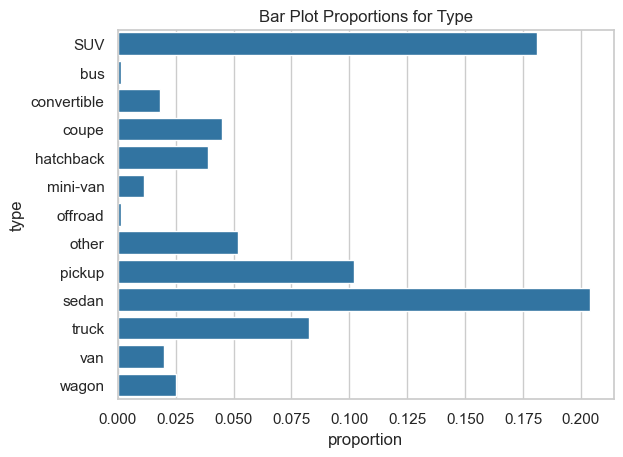

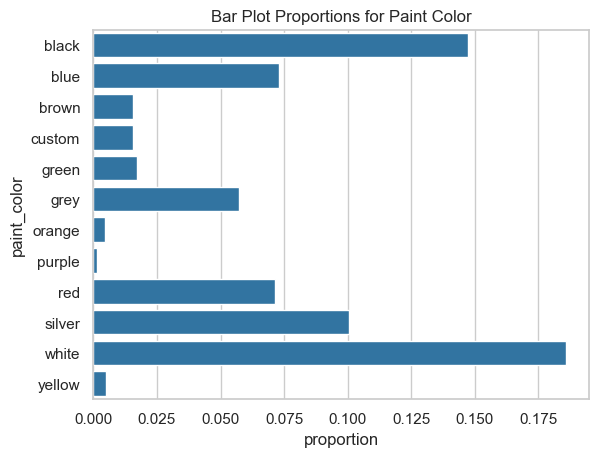

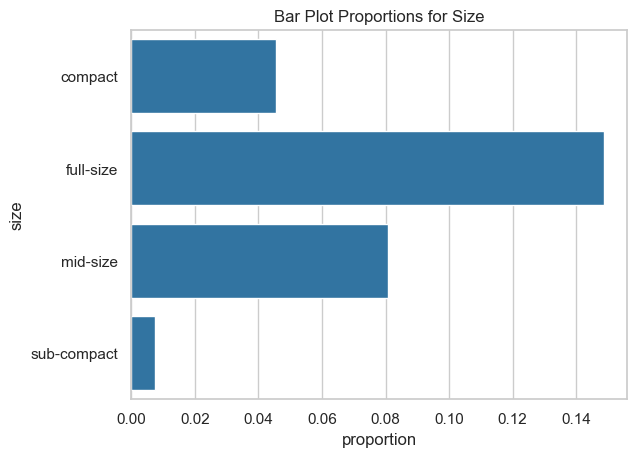

In [13]:
# Unusual categories should probably be removed
    # type: bus, offroad
    # fuel: electric
    # title_status: lien, missing, parts only, salvage
    # condition: salvage, new (since used car dealer)
for col in categ_cols:
    counts = df[col].value_counts(normalize=True, dropna=False).sort_index().reset_index()
    sns.barplot(data=counts, y=col, x='proportion')
    plt.title(f'Bar Plot Proportions for {col.replace('_', ' ').title()}')
    plt.show()
    plt.savefig(f'images/bar_{col}.png')
    plt.close()

**Steps for Understanding Relationship Between Target & Predictor Variables**
- Correlations and scatter plots of prices VS numeric predictors (year, odometer, cylinders)
- ANOVA tests + bar plots for group-level average prices in categorical predictors

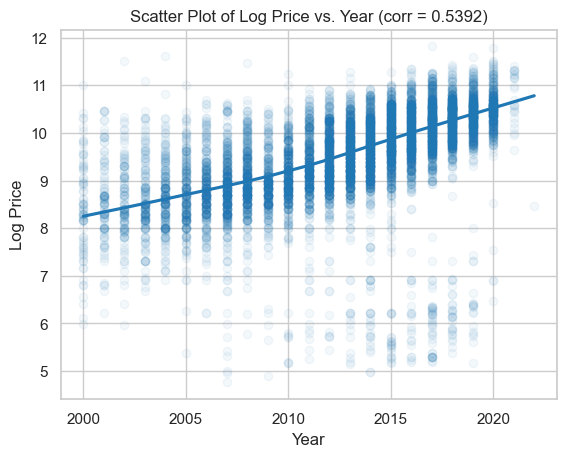

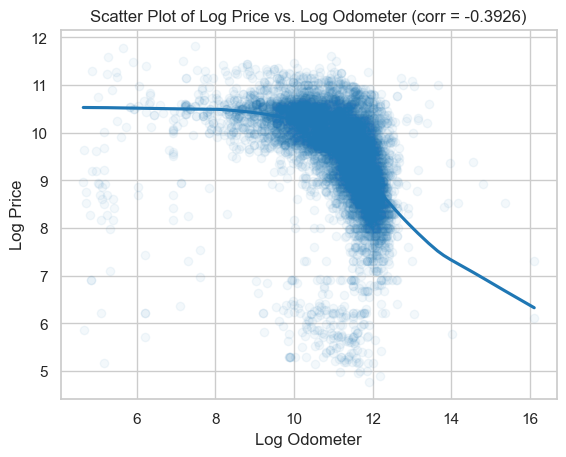

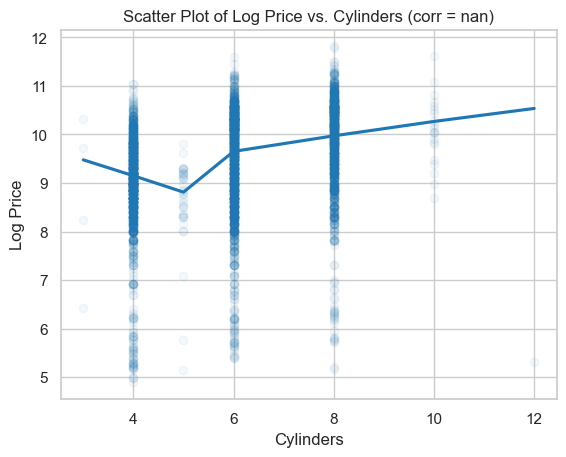

In [14]:
# Scatter plots of log price vs. numeric predictors (with lowess fit)
# Prices increase with year,  while they decrease with odometer (but only beyond a certain point)
sample = df.sample(10000).reset_index(drop=True)
sample = sample[sample['price'] > 100]
sample = sample[sample['odometer'] > 100]
sample = sample[sample['year'] >= 2000]

for col in numeric_cols:

    if col == 'odometer':
        col = 'log_odometer'

    corr = np.corrcoef(sample[col], sample['log_price'])[0,1]
    xlab = col.replace('_', ' ').title()
    sns.regplot(data=sample, x=col, y='log_price', scatter_kws=dict(alpha=0.05), lowess=True)
    plt.xlabel(xlab)
    plt.ylabel('Log Price')
    plt.title(f'Scatter Plot of Log Price vs. {xlab} (corr = {corr:.4f})')
    plt.show()
    plt.savefig(f'images/scatter_{col}.png')
    plt.close()


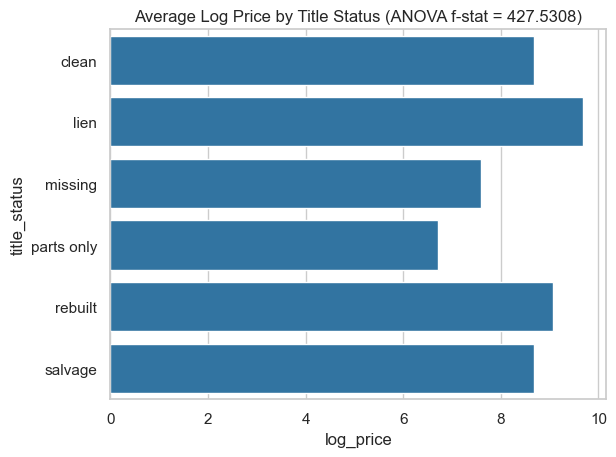

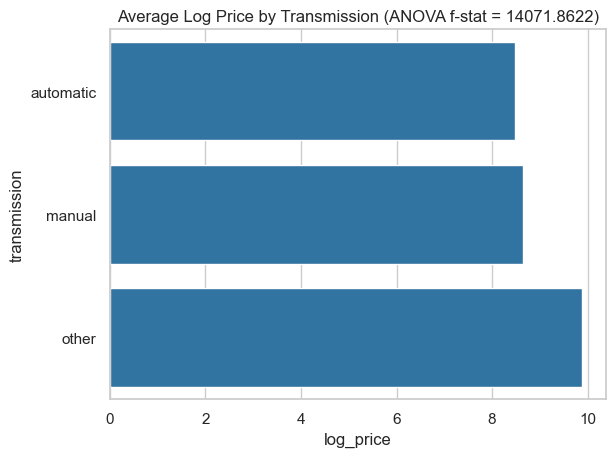

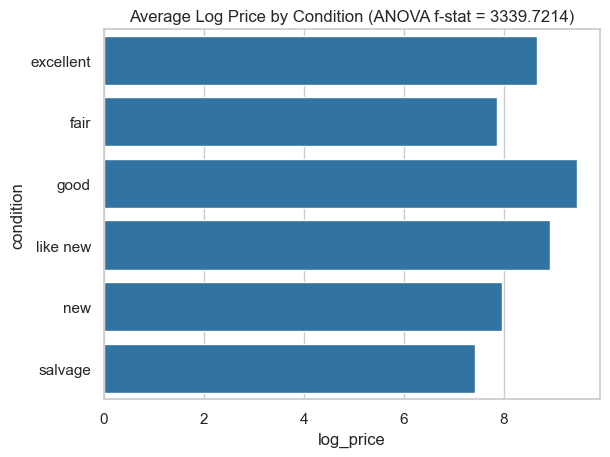

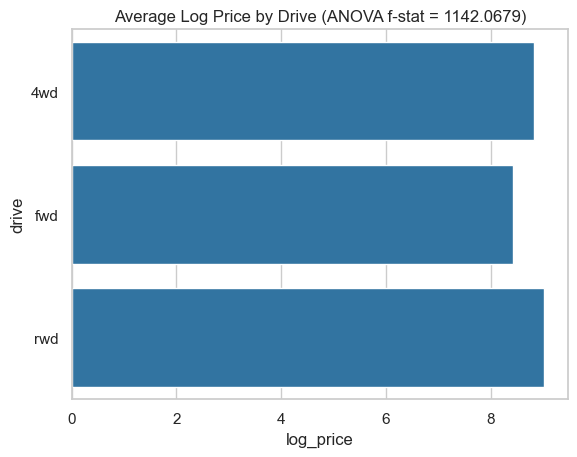

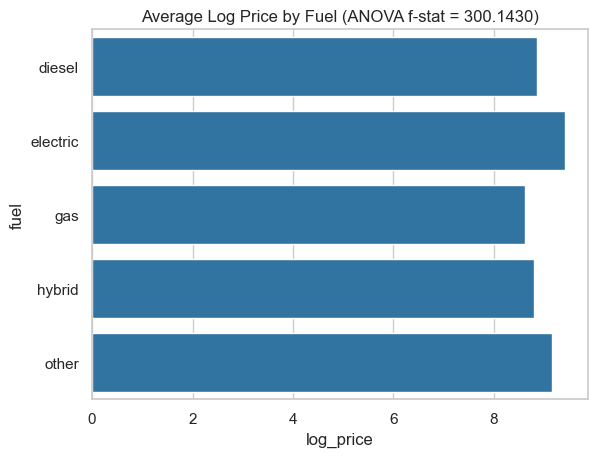

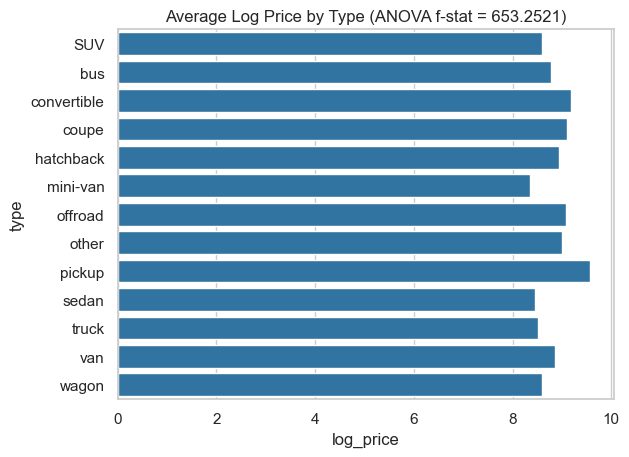

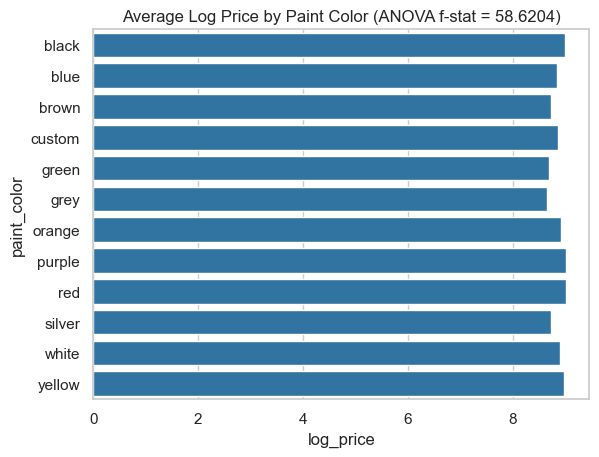

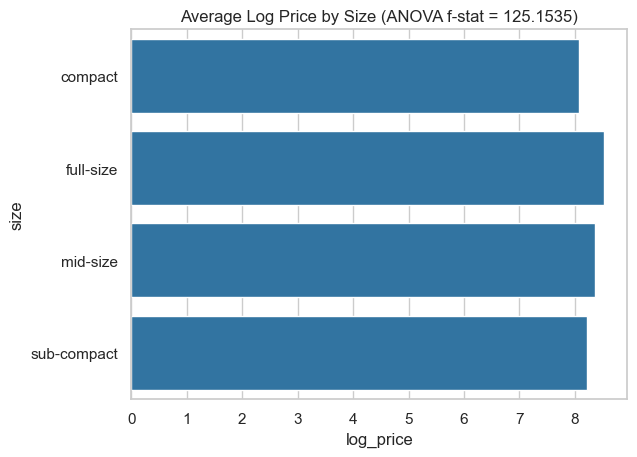

In [15]:
# Most categorical predictors have stat-sig diffs in averages across groups
for col in categ_cols:

    # ANOVA test for equal average across groups
    groups = [vals['log_price'].to_numpy() for _, vals in df.groupby(col)]
    res = anova_oneway(groups, use_var='unequal', welch_correction=True)
    fstat, pvalue = res.statistic, res.pvalue

    # Bar plot of group-level averages
    avg = df.groupby(col)['log_price'].mean().reset_index()
    sns.barplot(data=avg, y=col, x='log_price')
    plt.title(f'Average Log Price by {col.replace("_", " ").title()} (ANOVA f-stat = {fstat:.4f})')
    plt.show()
    plt.savefig(f'images/avg_{col}.png')
    plt.close()




### Data Preparation

After our initial exploration and fine-tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`. 

Grouping predictors into categories

In [16]:
import pandas as pd
pd.options.display.max_columns = 30
pd.options.display.float_format = '{:.7g}'.format


In [17]:
# Read in analysis data
df = pd.read_csv('data/vehicles.csv')
df = df.drop(columns=['id','VIN','region','state'])

numeric_cols = ['year', 'odometer', 'cylinders']
highdim_cols = ['manufacturer','model']
categ_cols = list(set(df.columns) - set(numeric_cols) - set(highdim_cols) - {'price'})


Dropping rows

In [18]:
# Drop rows when all predictors are missing
df = df[df[numeric_cols + categ_cols].notnull().any(axis=1)]

# Drop missing prices
df = df[df['price'].notnull()]

# Only keep prices above $100 but below $80k
df = df[(df['price'] >= 100) & (df['price'] <= 80000)]

# Only keep used cars with odometers above 100 miles but below 300k miles
df = df[(df['odometer'] >= 100) & (df['odometer'] <= 300000)]

# Drop cars produced prior to 1960
df = df[df['year'] >= 2000]

# Drop unusual categories
df = df[~df['title_status'].isin(['lien', 'missing', 'parts only','salvage'])]
df = df[~df['type'].isin(['bus', 'offroad'])]
df = df[~df['condition'].isin(['salvage','new'])]
df = df[~df['fuel'].isin(['electric'])]


# Trim outliers for price and odometer using IQR rule of thumb
# (optional: can clip outliers within pipeline to avoid leakage)
# for col in ['price','odometer']:
#     q1, q3 = df[col].quantile([0.25,0.75])
#     iqr = q3 - q1
#     valid = (df[col] > q1 - 1.5 * iqr) & (df[col] < q3 + 1.5 * iqr)
#     df = df[valid]

Transforming columns

In [19]:
# Convert cylinders into numeric
df['cylinders'] = df['cylinders'].str.replace(' cylinders', '')
df['cylinders'] = df['cylinders'].str.replace('other', '')
df['cylinders'] = pd.to_numeric(df['cylinders'], errors='coerce')

# Log transformations for price and odometer
df['price'] = np.log(1+df['price'])
df['odometer'] = np.log(1+df['odometer'])

# Year should be relative to 2000
df['year'] = df['year'] - 2000

# Create "missing" group for categorical predictors
for col in categ_cols:
    df[col] = df[col].fillna('missing')

In [20]:
firstcols = ['price','odometer','year','cylinders','manufacturer','model']
colorder = firstcols + [col for col in df.columns if col not in firstcols]
df = df[colorder]
display(df.columns)
df.head(5)

Index(['price', 'odometer', 'year', 'cylinders', 'manufacturer', 'model',
       'condition', 'fuel', 'title_status', 'transmission', 'drive', 'size',
       'type', 'paint_color'],
      dtype='object')

,price,odometer,year,cylinders,manufacturer,model,condition,fuel,title_status,transmission,drive,size,type,paint_color
27,10.42201,10.96689,14,8,gmc,sierra 1500 crew cab slt,good,gas,clean,other,missing,missing,pickup,white
28,10.02531,11.17367,10,8,chevrolet,silverado 1500,good,gas,clean,other,missing,missing,pickup,blue
29,10.58636,9.860632,20,8,chevrolet,silverado 1500 crew,good,gas,clean,other,missing,missing,pickup,red
30,10.34145,10.62437,17,8,toyota,tundra double cab sr,good,gas,clean,other,missing,missing,pickup,red
31,9.615872,11.75979,13,6,ford,f-150 xlt,excellent,gas,clean,automatic,rwd,full-size,truck,black


### Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

In [24]:
# Numpy and pandas
import numpy as np
import pandas as pd

# Train/test splits and regression model
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error

# Pre-processing pipelines
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

In [23]:
# Additional modules for winsorization and target encoding
# !pip install feature-engine
# !pip install category-encoders
from feature_engine.outliers import Winsorizer
from category_encoders import TargetEncoder

In [ ]:
# # columns
# num_cols = ['age','log_odometer']
# ohe_cols = ['fuel','transmission','drive','type','state','region']     # low-cardinality
# te_cols  = ['manufacturer','model']                                     # high-cardinality

# # data
# dfm = df.dropna(subset=['price']).copy()
# X = dfm[num_cols + ohe_cols + te_cols]
# y = dfm['price'].astype(float)

# X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, random_state=42)

# # numeric: impute → IQR winsorize (clip) → scale
# num_pipe = Pipeline([
#     ('imp', SimpleImputer(strategy='median')),
#     ('winsor', Winsorizer(capping_method='iqr', tail='both', fold=1.5)),
#     ('sc', StandardScaler()),
# ])

# # categoricals (OHE): missing label → rare grouping → OHE
# ohe_pipe = Pipeline([
#     ('imp',  SimpleImputer(strategy='constant', fill_value='__MISSING__')),
#     ('rare', RareLabelEncoder(tol=0.01, n_categories=1, replace_with='__RARE__')),
#     ('ohe',  OneHotEncoder(handle_unknown='ignore', drop=None)),
# ])

# # categoricals (TE): missing label → TargetEncoder (smoothed, leakage-safe in CV)
# te_pipe = Pipeline([
#     ('imp', SimpleImputer(strategy='constant', fill_value='__MISSING__')),
#     ('te',  TargetEncoder(smoothing=10, min_samples_leaf=20))
# ])

# prep = ColumnTransformer([
#     ('num', num_pipe, num_cols),
#     ('ohe', ohe_pipe, ohe_cols),
#     ('te',  te_pipe,  te_cols),
# ], verbose_feature_names_out=False)

# pipe = Pipeline([
#     ('prep', prep),
#     ('model', Lasso(max_iter=10000, random_state=42)),
# ])

# grid = GridSearchCV(
#     pipe,
#     {'model__alpha': np.logspace(-4, 1, 20)},
#     scoring='neg_root_mean_squared_error',
#     cv=5, n_jobs=-1, refit=True
# )
# grid.fit(X_tr, y_tr)

# y_hat = grid.best_estimator_.predict(X_te)
# rmse = mean_squared_error(y_te, y_hat, squared=False)
# print(f"Best alpha: {grid.best_params_['model__alpha']:.4g} | Test RMSE: {rmse:,.2f}")


### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high-quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight into drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine-tuning their inventory.